In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split
import sklearn.linear_model as lm 
from sklearn.metrics import r2_score,accuracy_score,mean_squared_error,confusion_matrix,classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans 
import xgboost as xgb
from scipy import stats
from sklearn.impute import SimpleImputer


In [2]:
def df_summary(df):
    print(f"Dataset Shape: {df.shape}")
    
    summary = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary = summary.reset_index()
    summary['Column'] = summary['index']
    summary = summary[['Column', 'dtypes']]
    
    summary['#Missing'] = df.isnull().sum().values
    summary['#Unique'] = df.nunique().values
    summary['Example'] = df.loc[0].values
    
    # Calculate entropy for each column
    for name in summary['Column'].value_counts().index:
        summary.loc[summary['Column'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2), 2)
    
    
     # Create a separate DataFrame for numerical statistics
    numerical_cols = df.select_dtypes(include=['number']).columns
    numerical_summary = pd.DataFrame(index=numerical_cols)
    numerical_summary['Mean'] = df[numerical_cols].mean()
    numerical_summary['Median'] = df[numerical_cols].median()
    numerical_summary['StdDev'] = df[numerical_cols].std()
    numerical_summary['Min'] = df[numerical_cols].min()
    numerical_summary['Max'] = df[numerical_cols].max()
    
    # Merge numerical statistics with the summary DataFrame
    summary = summary.merge(numerical_summary, left_on='Column', right_index=True, how='left')
    
   
    
    
    return summary


**Models**

After doing all the hard work preparing data, I finally get to the exciting part of building models. In this section, I mainly focus on predicting ratings (review scores), which is a scalar score given by customers to indicate their level of satisfaction with orders. 

In predicting ratings, I have two setups:
1. Predicting ratings without knowing the review text.
2. Predicting ratings given the review text. *(For future work)*

*For now, I will only focus on the first part.*

In [3]:
df=pd.read_pickle("preprocessing_dataset.pickle")



In [4]:
seed=42

**Hypothesis:** Right now I am assuming the relationship between the features and the target variable is linear (review_score_factor).

###  Linear Regression

In this section, I perform a simple Linear Regression on the `feature_df` for the purpose of predicting the review score. After selecting the attributes as features and the `review_score` column as the label, I split the data into training and testing sets with a size of 80% and 20%, respectively.

In [5]:
rating = df['review_score_factor']

drop_columns = ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', \
                'order_delivered_customer_date', 'order_estimated_delivery_date', 'review_id', 'review_comment_title', 'review_score', \
                'review_creation_date', 'review_comment_message', 'review_answer_timestamp', 'payment_sequential', 'payment_type', 'customer_unique_id', \
                'customer_zip_code_prefix', 'customer_city', 'customer_state', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', \
                'freight_value', 'product_category_name','product_length_cm', 'product_height_cm','product_width_cm', \
                'seller_zip_code_prefix', 'seller_city', 'seller_state', 'review_score_factor']

feature = df.drop(drop_columns, axis=1)


In [6]:

# Select only the delivery-related columns
delivery_cols = ['delivery_duration', 'actual_est_delivery_diff']

# Apply median imputation
imputer = SimpleImputer(strategy='median')
feature[delivery_cols] = imputer.fit_transform(feature[delivery_cols])

# Check if missing values are removed
print(feature.isnull().sum().sort_values(ascending=False))  # Should be all zeros for delivery columns


payment_installments                              0
payment_value                                     0
product_name_length                               0
product_description_length                        0
product_photos_qty                                0
                                                 ..
product_category_name_sinalizacao_e_seguranca     0
product_category_name_tablets_impressao_imagem    0
product_category_name_telefonia                   0
product_category_name_telefonia_fixa              0
product_category_name_utilidades_domesticas       0
Length: 134, dtype: int64


In [7]:
x_train_lr, x_test_lr, y_train_lr, y_test_lr = train_test_split(feature, rating, test_size = 0.2, random_state = seed)


In [8]:
print(x_train_lr[['delivery_duration', 'actual_est_delivery_diff']].corrwith(y_train_lr))


delivery_duration          -0.269920
actual_est_delivery_diff    0.202235
dtype: float64


In [9]:
reg = lm.LinearRegression().fit(x_train_lr, y_train_lr)

# Use the model to predict on the test set and save these predictions as `y_pred_lr`
y_pred_lr = reg.predict(x_test_lr)

# Find the R-squared score and store the value in `score`
score = reg.score(x_test_lr, y_test_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test_lr.values, y_pred_lr))

print(f'The R2 score in this linear regression model is {round(score, 5)}')
print(f'The RMSE in this linear regression model is {round(rmse_lr, 5)}, which is about {100*round(rmse_lr/np.mean(rating),2)}% of \
the mean rating score.')


The R2 score in this linear regression model is 0.13543
The RMSE in this linear regression model is 0.69411, which is about 49.0% of the mean rating score.


### Model Performance Interpretation

#### 🔹 R² Score: 0.13543
The R-squared (R²) score measures how well our model explains the variance in `review_score`. It ranges from 0 to 1, where:

- **1.0** → Perfect fit (model explains 100% of the variance).
- **0.0** → Model explains nothing (no better than predicting the average rating).
- **Negative** → Model performs worse than a simple average prediction.

📌 With R² = 0.13543, our model explains only ~13.54% of the variation in `review_score`, meaning most of the factors influencing review scores are not captured by the model.

#### 🔹 Root Mean Squared Error (RMSE): 0.69411
RMSE measures the average magnitude of prediction errors. Since `review_score` is likely on a 1 to 5 scale, an RMSE of 0.69411 means that, on average, our predictions deviate by ~0.69 points from actual review scores.

### Ridge Regression

In [10]:
lambdas=np.linspace(0.01,100,100)
ridgecv=lm.RidgeCV(alphas=lambdas,scoring='neg_mean_squared_error')
ridgecv.fit(x_train_lr,y_train_lr)
ridge_select=ridgecv.alpha_
print(ridge_select)

40.41


In [11]:
reg_ridge=lm.Ridge(alpha=ridge_select)
reg_ridge.fit(x_train_lr,y_train_lr)
y_pred_lr=reg_ridge.predict(x_test_lr)
ridge_score = reg_ridge.score(x_test_lr, y_test_lr)
ridge_rmse_lr = np.sqrt(mean_squared_error(y_test_lr.values, y_pred_lr))

print(f'The R2 score in this ridge regression model is {ridge_score}')
print(f'The RMSE in this ridge regression model is {round(ridge_rmse_lr, 5)}, which is about {100*round(ridge_rmse_lr/np.mean(rating),2)}% of \
the mean rating score.')

The R2 score in this ridge regression model is 0.1355041059365949
The RMSE in this ridge regression model is 0.69408, which is about 49.0% of the mean rating score.


Not much difference

### Lasso Regression

In [12]:
lambdas=np.linspace(0.00001,0.001,100)
lassocv=lm.LassoCV(alphas=lambdas)
lassocv.fit(x_train_lr,y_train_lr)
lassocv_select=lassocv.alpha_

/home/hasanksi255/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 83.12477322833001, tolerance: 4.168810991149256
  model = cd_fast.enet_coordinate_descent_gram(


In [13]:
reg_lasso = lm.Lasso(alpha=lassocv_select)
reg_lasso.fit(x_train_lr, y_train_lr)

# Use the model to predict on the test set and save these predictions as `y_pred`
y_pred_lr = reg_lasso.predict(x_test_lr)

# Find the R-squared score and store the value in `ridge_score`
lasso_score = reg_lasso.score(x_test_lr, y_test_lr)
lasso_rmse_lr = np.sqrt(mean_squared_error(y_test_lr.values, y_pred_lr))

print(f'The R2 score in this lasso regression model is {lasso_score}')
print(f'The RMSE in this lasso regression model is {round(lasso_rmse_lr, 5)}, which is about {100*round(lasso_rmse_lr/np.mean(rating),2)}% of \
the mean rating score.')

The R2 score in this lasso regression model is 0.13555660483423904
The RMSE in this lasso regression model is 0.69406, which is about 49.0% of the mean rating score.


### Logistic Regression(classifier)

In [14]:
df.loc[df['review_score_factor']==2,"review_score_factor_boolean"]=1.0
df.loc[df['review_score_factor']<2,"review_score_factor_boolean"]=0.0
labels=df['review_score_factor_boolean']
drop_columns_log=drop_columns
drop_columns_log.append('review_score_factor_boolean')
features=df.drop(drop_columns_log,axis=1)
imputer = SimpleImputer(strategy='median')
features[delivery_cols] = imputer.fit_transform(features[delivery_cols])
combined_df=pd.concat([features,labels],axis=1)


In [15]:
x_train,x_test,y_train,y_test=train_test_split(features,labels,random_state=42,test_size=0.2)


In [16]:
import time 

In [17]:
start = time.time()


logreg = lm.LogisticRegression(penalty='l2', max_iter=1000)


logreg.fit(x_train, y_train)


pred1 = logreg.predict(x_test)

end = time.time()


print(f"Time used for Logistic Regression: {end - start:.5f} sec\n")


log_acc = accuracy_score(y_test, pred1)
print(f'The test accuracy is {round(log_acc, 5)}')

Time used for Logistic Regression: 60.39374 sec

The test accuracy is 0.63039


/home/hasanksi255/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Analysis on Logistic Regression model

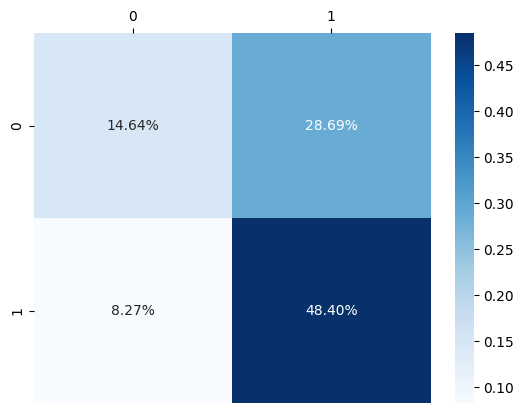

In [18]:
fig = sns.heatmap(confusion_matrix(y_test, pred1) / len(y_test), annot=True, fmt='.2%', cmap='Blues')
fig.axes.xaxis.set_ticks_position("top")


In [19]:
print(classification_report(y_test,pred1))

              precision    recall  f1-score   support

         0.0       0.64      0.34      0.44     10022
         1.0       0.63      0.85      0.72     13105

    accuracy                           0.63     23127
   macro avg       0.63      0.60      0.58     23127
weighted avg       0.63      0.63      0.60     23127



### Logistic Regression with PCA

In order to get rid of any feature redundancies and remove the noise, PCA is used before building a Logistic Regression model. While reducing the dimensionality of a dataset, the overall interpretability of the data can be increased.

The cutoff line, 0.9, is selected for choosing the proper number of components. In other words, we want our training features to collectively explain 90% of the variance.


In [20]:
scaler=StandardScaler()
x_train_sc=scaler.fit_transform(x_train)
x_test_sc=scaler.transform(x_test)
pca=PCA(n_components=x_train_sc.shape[1])
x_train_pca=pca.fit_transform(x_train_sc)
x_test_pca=pca.transform(x_test_sc)

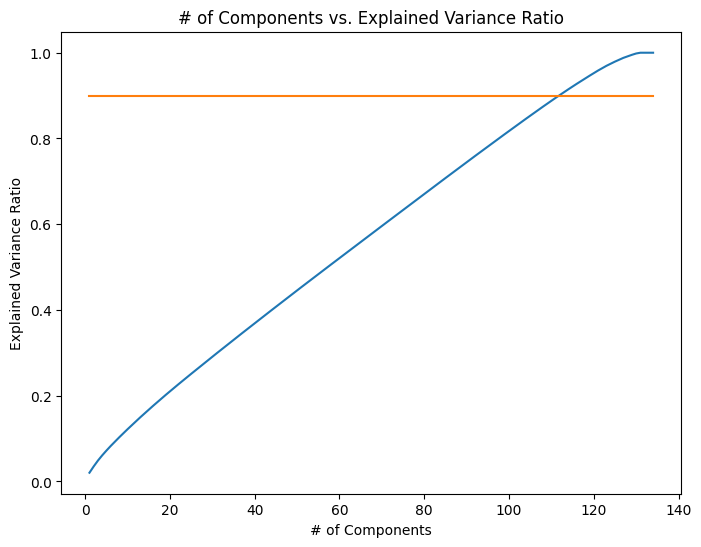

We first surpass 90% explained variance with 112 components.


In [21]:
cum_expl_var_ratios_lr = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(cum_expl_var_ratios_lr)+1), cum_expl_var_ratios_lr)
plt.plot(np.arange(1, len(cum_expl_var_ratios_lr)+1), [0.90]*len(cum_expl_var_ratios_lr))
plt.ylabel("Explained Variance Ratio")
plt.xlabel("# of Components")
plt.title("# of Components vs. Explained Variance Ratio")
plt.grid(False)
plt.show()

for i in range(len(cum_expl_var_ratios_lr)):
  if cum_expl_var_ratios_lr[i] >= 0.90:
    print("We first surpass 90% explained variance with " + str(i + 1) + " components.")
    break

In [22]:
pca = PCA(n_components = 111)

x_train_pca = pca.fit_transform(x_train_sc)
x_test_pca = pca.transform(x_test_sc)

log_reg_pca = lm.LogisticRegression()
log_reg_pca.fit(x_train_pca, y_train)

# Use the model to predict on the PCA transformed test set and save these predictions as `y_pred_pca`
y_pred_pca = log_reg_pca.predict(x_test_pca)

# Calculating test accuracy, RMSE and R2 score
score_pca_log = r2_score(y_test.values, y_pred_pca)
rmse_pca_log = np.sqrt(mean_squared_error(y_test.values, y_pred_pca))
test_accuracy = log_reg_pca.score(x_test_pca, y_test)

print(f'The test accuracy is {round(test_accuracy, 5)}')
print(f'The R2 score is {round(score_pca_log, 5)}.')
print(f'The RMSE score is {round(rmse_pca_log, 5)}.')

The test accuracy is 0.62749
The R2 score is -0.51699.
The RMSE score is 0.61033.


If I look at the test accuracy, I can see that there isn't an improvement in the model after applying PCA. This suggests that there isn't collinearity between the variables or noise that might negatively impact the model's performance.

From the models above, I noticed that the relationship between the features and rating scores is probably non-linear, which explains the relatively low R² score from the previous models. However, the score from logistic regression can be used as a baseline for further training.

### Why can logistic regression be used as a baseline?

Logistic regression is a simple yet effective model that helps establish a benchmark for classification tasks. It assumes a linear relationship between the independent variables (features) and the log-odds of the dependent variable (target). If logistic regression provides a reasonable accuracy, more complex models like decision trees, random forests, or neural networks can be compared against it to check for improvements. If a more complex model doesn't significantly outperform logistic regression, it may indicate that the dataset lacks enough non-linearity to justify using a more advanced approach.

### Linear Classifiers with Stochastic Gradient Descent Training

Stochastic Gradient Descent (SGD) is a simple yet very efficient approach to fitting linear classifiers and regressors under convex loss functions. By applying SGD, the model will have better efficiency. In this section, different loss functions are tried to explore the corresponding accuracy and time spent for them.


In [23]:
start = time.time()
clf = make_pipeline(StandardScaler(), \
                    lm.SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3))
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
end = time.time()
print(f"Time used for Logistic Reg: {end - start} sec\n")
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))

Time used for Logistic Reg: 3.6049511432647705 sec

Accuracy: 0.62


Computing for loss: hinge
Computing for loss: log_loss
Computing for loss: modified_huber
Computing for loss: perceptron
Computing for loss: squared_hinge


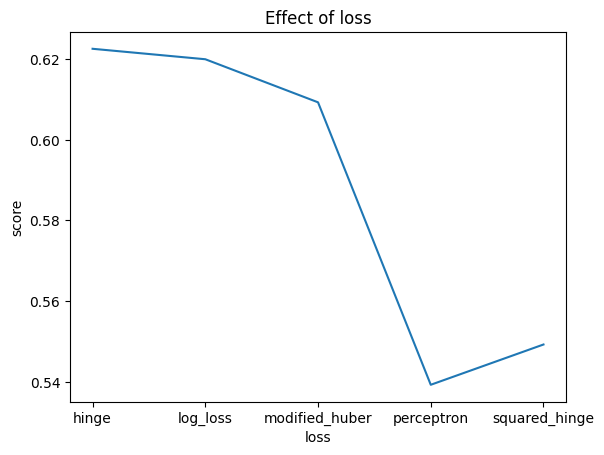

In [24]:
losses = ["hinge", "log_loss", "modified_huber", "perceptron", "squared_hinge"]
scores = []
times = []

for loss in losses:
    print(f'Computing for loss: {loss}')
    start = time.time()
    clf = make_pipeline(StandardScaler(), \
                        lm.SGDClassifier(loss=loss, max_iter=1000, tol=1e-3))
    clf.fit(x_train, y_train)
    score = clf.score(x_test, y_test)
    end = time.time()
    scores.append(score)
    times.append(end - start)

# Plot the loss functions' scores
plt.title("Effect of loss")
plt.xlabel("loss")
plt.ylabel("score")
plt.grid(False)
x = np.arange(len(losses))
plt.xticks(x, losses)
plt.plot(x, scores) 

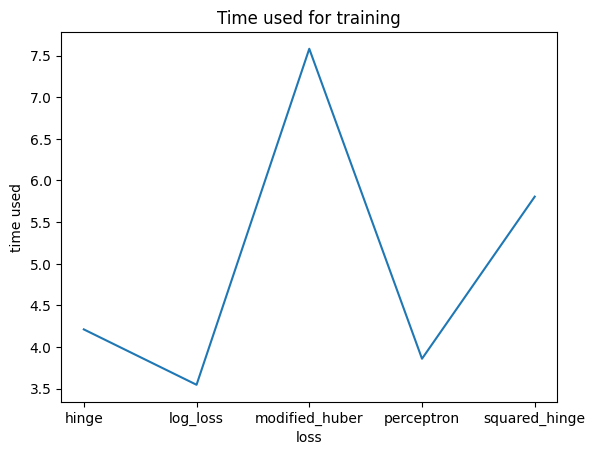

In [25]:
plt.title("Time used for training")
plt.xlabel("loss")
plt.ylabel("time used")
plt.grid(False)
x = np.arange(len(losses))
plt.xticks(x, losses)
plt.plot(x, times) 


### XGBoost

In [50]:
drop_columns = ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', \
                'order_delivered_customer_date', 'order_estimated_delivery_date', 'review_id', 'review_comment_title', 'review_score', \
                'review_creation_date', 'review_comment_message', 'review_answer_timestamp', 'payment_sequential', 'payment_type', 'customer_unique_id', \
                'customer_zip_code_prefix', 'customer_city', 'customer_state', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', \
                'freight_value', 'product_category_name','product_length_cm', 'product_height_cm', 'product_width_cm', \
                'seller_zip_code_prefix', 'seller_city', 'seller_state','review_score_factor_boolean']


rf_feature_df = df.drop(drop_columns, axis=1)
imputer = SimpleImputer(strategy='median')
rf_feature_df[delivery_cols] = imputer.fit_transform(rf_feature_df[delivery_cols])
train, test = train_test_split(rf_feature_df, test_size=0.2,random_state=seed)

# Split feature and label with our dataframe from random forest
Y_train = train['review_score_factor']
X_train =  train.drop('review_score_factor', axis=1)
Y_test = test['review_score_factor']
X_test =  test.drop('review_score_factor', axis=1)

# Create a scaler object
scaler = StandardScaler()

# Fit the scaler to the training data
scaler.fit(X_train)

# Transform the training and test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create an XGBoost classifier
model = xgb.XGBClassifier(max_depth=8, n_estimators=100)
model.fit(X_train_scaled, Y_train)


# Make predictions on the test set
predictions_te = model.predict(X_test_scaled)
predictions_tr = model.predict(X_train_scaled)

accuracy_tr = sum(Y_train == predictions_tr)/len(predictions_tr)
accuracy_te = sum(Y_test == predictions_te)/len(predictions_te)

print("Train accuracy: {}".format(accuracy_tr))
print("Test accuracy: {}".format(accuracy_te))


Train accuracy: 0.7092404816984844
Test accuracy: 0.6408959225148095


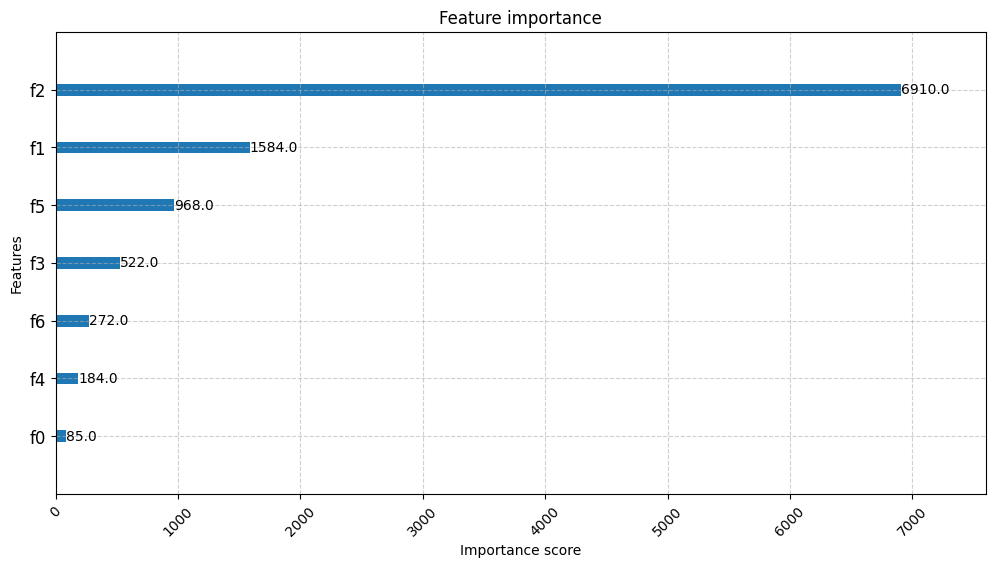

In [48]:
fig, ax = plt.subplots(figsize=(12, 6))  # Increase figure size
xgb.plot_importance(model, ax=ax, importance_type="weight")  # You can also try "gain" or "cover"
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=12)  # Increase font size for y-axis labels
plt.grid(True, linestyle="--", alpha=0.6)  # Add a grid for better visibility
plt.show()

In [46]:
# Get feature importance
feature_importance = model.feature_importances_

# Create a DataFrame with feature names and their importance scores
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
})

# Filter and sort by importance (keep only features with importance > 0)
important_features_df = feature_importance_df[feature_importance_df['Importance'] > 0.01].sort_values(by='Importance', ascending=False)

# Print the important features
important_features_df


,Feature,Importance
8,if_delivered,0.217717
6,price_factor,0.019953
9,actual_est_delivery_diff,0.018133
116,product_category_name_moveis_escritorio,0.012593
117,product_category_name_moveis_quarto,0.011101
74,product_category_name_cama_mesa_banho,0.010808
132,product_category_name_telefonia_fixa,0.010423


In [53]:
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score

In [54]:
def train_and_evaluate(model, X_train_scaled, Y_train, X_test_scaled, Y_test, model_name):
    model.fit(X_train_scaled, Y_train)
    predictions_te = model.predict(X_test_scaled)
    predictions_tr = model.predict(X_train_scaled)
    
    accuracy_tr = accuracy_score(Y_train, predictions_tr)
    accuracy_te = accuracy_score(Y_test, predictions_te)
    f1_te = f1_score(Y_test, predictions_te, average='weighted')  # F1-score for better evaluation

    print(f"{model_name} Train Accuracy: {accuracy_tr:.4f}")
    print(f"{model_name} Test Accuracy: {accuracy_te:.4f}")
    print(f"{model_name} Test F1 Score: {f1_te:.4f}")
    print("-" * 50)

# 🎯 **Tuned Random Forest**
rf_model = RandomForestClassifier(n_estimators=500, max_depth=15, min_samples_split=5, random_state=42)
train_and_evaluate(rf_model, X_train_scaled, Y_train, X_test_scaled, Y_test, "Random Forest")

# 🎯 **Tuned LightGBM**
lgb_model = LGBMClassifier(n_estimators=500, max_depth=10, learning_rate=0.03, num_leaves=50, random_state=42)
train_and_evaluate(lgb_model, X_train_scaled, Y_train, X_test_scaled, Y_test, "LightGBM")

xgb_model = xgb.XGBClassifier(n_estimators=500, max_depth=10, learning_rate=0.03, colsample_bytree=0.8, subsample=0.8, random_state=42)
train_and_evaluate(xgb_model, X_train_scaled, Y_train, X_test_scaled, Y_test, "XGBoost")


Random Forest Train Accuracy: 0.6221
Random Forest Test Accuracy: 0.6171
Random Forest Test F1 Score: 0.5071
--------------------------------------------------
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1457
[LightGBM] [Info] Number of data points in the train set: 92506, number of used features: 121
[LightGBM] [Info] Start training from score -1.824169
[LightGBM] [Info] Start training from score -1.296311
[LightGBM] [Info] Start training from score -0.570736
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

/home/hasanksi255/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/hasanksi255/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM Train Accuracy: 0.6594
LightGBM Test Accuracy: 0.6330
LightGBM Test F1 Score: 0.5511
--------------------------------------------------
XGBoost Train Accuracy: 0.7244
XGBoost Test Accuracy: 0.6511
XGBoost Test F1 Score: 0.5818
--------------------------------------------------
